<a href="https://colab.research.google.com/github/ElisabethShah/DS-Unit-2-Tree-Ensembles/blob/master/module2-random-forests/Random%20Forests%20-%20Assignment%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Tree Ensembles_ 

This sprint, your project is about water pumps in Tanzania. Can you predict which water pumps are faulty?

# Random Forests, Ordinal Encoding

## Objectives

* do feature engineering with dates
* clean data with outliers
* impute missing values
* do ordinal encoding with high-cardinality categoricals
* use scikit-learn for decision trees & random forests
* get and interpret feature importances of a tree-based model
* understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth
* understand how categorical encodings affect trees differently compared to linear models



## Summary 

**Try Tree Ensembles when you do machine learning with labeled, tabular data**
- "Tree Ensembles" means Random Forest or Gradient Boosting models. 
- [Tree Ensembles often have the best predictive accuracy](https://arxiv.org/abs/1708.05070) with labeled, tabular data.
- Why? Because trees can fit non-linear, non-[monotonic](https://en.wikipedia.org/wiki/Monotonic_function) relationships, and [interactions](https://christophm.github.io/interpretable-ml-book/interaction.html) between features.
- A single decision tree, grown to unlimited depth, will [overfit](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/). We solve this problem by ensembling trees, with bagging (Random Forest) or boosting (Gradient Boosting).
- Random Forest's advantage: may be less sensitive to hyperparameters. Gradient Boosting's advantage: may get better predictive accuracy.

**One-hot encoding isn’t the only way, and may not be the best way, of categorical encoding for tree ensembles.**
- For example, tree ensembles can work with arbitrary "ordinal" encoding! (Randomly assigning an integer to each category.) Compared to one-hot encoding, the dimensionality will be lower, and the predictive accuracy may be just as good or even better.


### Features

Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

- `amount_tsh` : Total static head (amount water available to waterpoint)
- `date_recorded` : The date the row was entered
- `funder` : Who funded the well
- `gps_height` : Altitude of the well
- `installer` : Organization that installed the well
- `longitude` : GPS coordinate
- `latitude` : GPS coordinate
- `wpt_name` : Name of the waterpoint if there is one
- `num_private` :  
- `basin` : Geographic water basin
- `subvillage` : Geographic location
- `region` : Geographic location
- `region_code` : Geographic location (coded)
- `district_code` : Geographic location (coded)
- `lga` : Geographic location
- `ward` : Geographic location
- `population` : Population around the well
- `public_meeting` : True/False
- `recorded_by` : Group entering this row of data
- `scheme_management` : Who operates the waterpoint
- `scheme_name` : Who operates the waterpoint
- `permit` : If the waterpoint is permitted
- `construction_year` : Year the waterpoint was constructed
- `extraction_type` : The kind of extraction the waterpoint uses
- `extraction_type_group` : The kind of extraction the waterpoint uses
- `extraction_type_class` : The kind of extraction the waterpoint uses
- `management` : How the waterpoint is managed
- `management_group` : How the waterpoint is managed
- `payment` : What the water costs
- `payment_type` : What the water costs
- `water_quality` : The quality of the water
- `quality_group` : The quality of the water
- `quantity` : The quantity of water
- `quantity_group` : The quantity of water
- `source` : The source of the water
- `source_type` : The source of the water
- `source_class` : The source of the water
- `waterpoint_type` : The kind of waterpoint
- `waterpoint_type_group` : The kind of waterpoint

### Labels

There are three possible values:

- `functional` : the waterpoint is operational and there are no repairs needed
- `functional needs repair` : the waterpoint is operational, but needs repairs
- `non functional` : the waterpoint is not operational

## Set up environment

In [1]:
# Install dependencies.
!pip install category_encoders

In [0]:
# Import libraries.
%matplotlib inline

import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

## Load data

In [0]:
# Define data source location.
LOCAL = '../data/tanzania/'
WEB = ('https://raw.githubusercontent.com/LambdaSchool/'
       'DS-Unit-2-Tree-Ensembles/master/data/tanzania/')
source = WEB

# Merge train_features.csv & train_labels.csv.
train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

# Read test_features.csv & sample_submission.csv.
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val.
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=0)

In [4]:
# Check data dimensions.
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

## Clean and wrangle data

In [0]:
def generate_location_cols(X, grouping, latitude, longitude):
  locations = X[[grouping, latitude, longitude]]
  locations = locations.groupby([grouping]).mean()
  locations = locations.to_dict()
  
  mean_latitudes = X[grouping].replace(locations['latitude'])
  mean_longitudes = X[grouping].replace(locations['longitude'])
  
  return (mean_latitudes, mean_longitudes)

In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime.
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], 
                                        infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column.
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded.
    X['pump_age'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random).
    X = X.drop(columns=['recorded_by', 'id'])
    
    # Drop duplicate columns.
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values.
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values.
    cols_with_zeros = ['construction_year', 
                       'longitude', 
                       'latitude', 
                       'gps_height', 
                       'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    # Add mean latitude and longtitude values for geographic groupings.
    X['ward_lat'], X['ward_long'] = generate_location_cols(X, 
                                                           'ward',
                                                           'latitude',
                                                           'longitude')
    X['lga_lat'], X['lga_long'] = generate_location_cols(X, 
                                                         'lga',
                                                         'latitude',
                                                         'longitude')
    X['region_lat'], X['region_long'] = generate_location_cols(X, 
                                                               'region',
                                                               'latitude',
                                                               'longitude')
    
    # Impute missing latitude values.
    X['latitude'] = X['latitude'].fillna(X['ward_lat'])
    X['latitude'] = X['latitude'].fillna(X['lga_lat'])
    X['latitude'] = X['latitude'].fillna(X['region_lat'])
    X['latitude'] = X['latitude'].mean()
    
    # Impute missing longitude values.
    X['longitude'] = X['longitude'].fillna(X['ward_long'])
    X['longitude'] = X['longitude'].fillna(X['lga_long'])
    X['longitude'] = X['longitude'].fillna(X['region_long'])
    X['longitude'] = X['longitude'].mean()

    # Drop now redundant mean latitude and longitude columns.
    X = X.drop(columns=['ward_lat', 'ward_long', 
                        'lga_lat', 'lga_long', 
                        'region_lat', 'region_long'])
    
    return X

In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

In [13]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('RF_baseline_submission.csv', index=False)

Validation Accuracy 0.7986531986531986


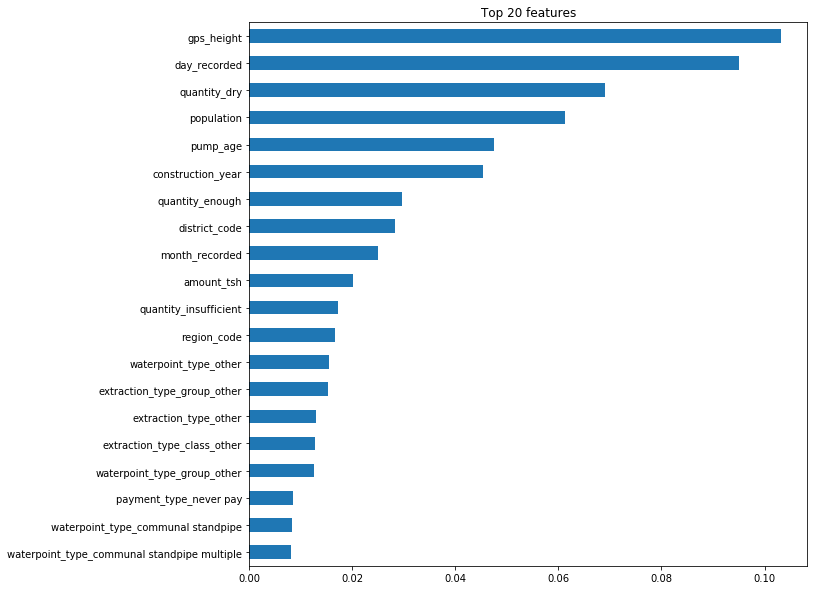

In [15]:
# Get feature importances
encoder = pipeline.named_steps['onehotencoder']
tree = pipeline.named_steps['randomforestclassifier']

feature_names = encoder.transform(X_val).columns

importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();